In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
from sklearn.neural_network import MLPRegressor

# Admissions Predictors

In [3]:
df = pd.read_csv('data.csv',  index_col=0, parse_dates=[0])

In [4]:
df

,admissions,discharges,occupancy,day,holiday,temp,feels_like,temp_min,temp_max
2014-04-03,12.0,4.0,8.0,3,0.0,0.236667,-4.625000,-1.404583,2.335417
2014-04-04,11.0,9.0,10.0,4,0.0,2.353929,-3.518214,-0.639286,4.970714
2014-04-05,12.0,1.0,21.0,5,0.0,2.683571,-5.528214,1.019643,4.161786
2014-04-06,8.0,3.0,26.0,6,0.0,0.907917,-4.641250,-1.264583,3.205417
2014-04-07,17.0,15.0,28.0,0,0.0,3.793750,-0.637917,0.904167,7.858333
...,...,...,...,...,...,...,...,...,...
2019-03-27,15.0,19.0,111.0,2,0.0,-0.729167,-5.525833,-2.935000,1.388750
2019-03-28,17.0,21.0,107.0,3,0.0,4.163333,-1.817500,1.362500,7.126250
2019-03-29,16.0,20.0,103.0,4,0.0,5.317083,1.726667,3.033333,7.530417
2019-03-30,17.0,10.0,110.0,5,0.0,3.933750,-0.053437,-0.351250,7.706563


In [5]:
admissions_predictors = pd.DataFrame(df['occupancy'])

In [6]:
admissions_predictors['lf_admissions'] = admissions_predictors['occupancy'].rolling(3, win_type=None).mean()
admissions_predictors['hf_admissions'] = admissions_predictors['occupancy']-admissions_predictors['lf_admissions']
admissions_predictors['day'] = np.sin(2*np.pi*df['day'].values/6)
admissions_predictors['holiday'] = df['holiday']
admissions_predictors['temp_min']= df['temp_min']
admissions_predictors['temp_max']= df['temp_max']
admissions_predictors['temp'] = df['temp']
admissions_predictors['feels_like']=df['feels_like']
admissions_predictors = admissions_predictors.dropna()
admissions_predictors

,occupancy,lf_admissions,hf_admissions,day,holiday,temp_min,temp_max,temp,feels_like
2014-04-05,21.0,13.000000,8.000000,-8.660254e-01,0.0,1.019643,4.161786,2.683571,-5.528214
2014-04-06,26.0,19.000000,7.000000,-2.449294e-16,0.0,-1.264583,3.205417,0.907917,-4.641250
2014-04-07,28.0,25.000000,3.000000,0.000000e+00,0.0,0.904167,7.858333,3.793750,-0.637917
2014-04-08,26.0,26.666667,-0.666667,8.660254e-01,0.0,1.782000,6.493333,4.217667,-0.272000
2014-04-09,33.0,29.000000,4.000000,8.660254e-01,0.0,1.533750,4.711667,3.203333,-2.495000
...,...,...,...,...,...,...,...,...,...
2019-03-27,111.0,114.333333,-3.333333,8.660254e-01,0.0,-2.935000,1.388750,-0.729167,-5.525833
2019-03-28,107.0,111.000000,-4.000000,1.224647e-16,0.0,1.362500,7.126250,4.163333,-1.817500
2019-03-29,103.0,107.000000,-4.000000,-8.660254e-01,0.0,3.033333,7.530417,5.317083,1.726667
2019-03-30,110.0,106.666667,3.333333,-8.660254e-01,0.0,-0.351250,7.706563,3.933750,-0.053437


## Low Frequency Admission Predictors

In [7]:
lag = 3
y = admissions_predictors['occupancy'].iloc[lag:].values
admissions_lf_dict = {}

for i in range(len(admissions_predictors)-lag):
    admissions_lf_dict[i] = admissions_predictors['lf_admissions'].iloc[i:i+lag+1].values

In [8]:
lf_predictors = pd.DataFrame(admissions_lf_dict).T
lf_y = lf_predictors[lag].values #the target values
lf_predictors = lf_predictors.drop([lag], axis=1)

derivative = lf_predictors.apply(np.gradient, axis=1, result_type='expand')

lag_column_names = []
dlag_column_names = []
for i in range(lag):
    string = 'lag_'+str(i)
    dstring = 'dlag_'+str(i)
    lag_column_names = np.append(lag_column_names, string) 
    dlag_column_names = np.append(dlag_column_names, string)    

lf_predictors.columns = lag_column_names
derivative.columns = dlag_column_names

In [9]:
lf_predictors['mean'] = lf_predictors.mean(numeric_only=True, axis=1)
lf_predictors['std'] = lf_predictors.std(numeric_only=True, axis=1)
lf_predictors['max'] = lf_predictors.max(numeric_only=True, axis=1)
lf_predictors['min'] = lf_predictors.min(numeric_only=True, axis=1)

derivative['dmean'] = derivative.mean(numeric_only=True, axis=1)
derivative['dstd'] = derivative.std(numeric_only=True, axis=1)
derivative['dmax'] = derivative.std(numeric_only=True, axis=1)
derivative['dmin'] = derivative.std(numeric_only=True, axis=1)

In [10]:
lf_predictors = pd.concat([lf_predictors, derivative], axis=1, sort=False)
lf_predictors

,lag_0,lag_1,lag_2,mean,std,max,min,lag_0,lag_1,lag_2,dmean,dstd,dmax,dmin
0,13.000000,19.000000,25.000000,19.000000,4.898979,25.000000,4.898979,6.000000,6.000000,6.000000,6.000000,0.000000,2.683282,2.550833
1,19.000000,25.000000,26.666667,23.555556,3.292341,26.666667,3.292341,6.000000,3.833333,1.666667,3.833333,1.769076,1.788702,1.733017
2,25.000000,26.666667,29.000000,26.888889,1.640536,29.000000,1.640536,1.666667,2.000000,2.333333,2.000000,0.272166,0.807860,0.800973
3,26.666667,29.000000,29.333333,28.333333,1.186342,29.333333,1.186342,2.333333,1.333333,0.333333,1.333333,0.816497,0.743925,0.694343
4,29.000000,29.333333,28.666667,29.000000,0.272166,29.333333,0.272166,0.333333,-0.166667,-0.666667,-0.166667,0.408248,0.437156,0.438989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,112.333333,115.333333,115.666667,114.444444,1.498971,115.666667,1.498971,3.000000,1.666667,0.333333,1.666667,1.088662,0.977603,0.905194
1815,115.333333,115.666667,114.333333,115.111111,0.566558,115.666667,0.566558,0.333333,-0.500000,-1.333333,-0.500000,0.680414,0.791137,0.828397
1816,115.666667,114.333333,111.000000,113.666667,1.962614,115.666667,1.962614,-1.333333,-2.333333,-3.333333,-2.333333,0.816497,1.576162,1.944217
1817,114.333333,111.000000,107.000000,110.777778,2.997942,114.333333,2.997942,-3.333333,-3.666667,-4.000000,-3.666667,0.272166,1.777199,2.477894


## High Frequency Admission Predictors

In [11]:
len(admissions_predictors)
lag = 3
admissions_hf_dict = {}
min_temp_hf_dict = {}
max_temp_hf_dict = {}
mean_temp_hf_dict = {}
feels_like_hf_dict = {}

dayofweek_hf = admissions_predictors['day'].iloc[lag:].values
holidays_hf = admissions_predictors['holiday'].iloc[lag:].values

for i in range(len(admissions_predictors)-lag):
    admissions_hf_dict[i] = admissions_predictors['hf_admissions'].iloc[i:i+lag+1].values
    
    min_temp_hf_dict[i] = admissions_predictors['temp_min'].iloc[i:i+lag+1].values
    max_temp_hf_dict[i] = admissions_predictors['temp_max'].iloc[i:i+lag+1].values
    mean_temp_hf_dict[i] = admissions_predictors['temp'].iloc[i:i+lag+1].values
    feels_like_hf_dict[i] = admissions_predictors['feels_like'].iloc[i:i+lag+1].values

In [12]:
weather_1 = pd.DataFrame(min_temp_hf_dict).T
weather_2 = pd.DataFrame(max_temp_hf_dict).T
weather_3 = pd.DataFrame(mean_temp_hf_dict).T
weather_4 = pd.DataFrame(feels_like_hf_dict).T

In [13]:
hf_predictors = pd.DataFrame(admissions_hf_dict).T
hf_y = hf_predictors[lag].values #the target values
hf_predictors = hf_predictors.drop([lag], axis=1)

derivative = hf_predictors.apply(np.gradient, axis=1, result_type='expand')

lag_column_names = []
dlag_column_names = []
for i in range(lag):
    string = 'lag_'+str(i)
    dstring = 'dlag_'+str(i)
    lag_column_names = np.append(lag_column_names, string) 
    dlag_column_names = np.append(dlag_column_names, string)    

hf_predictors.columns = lag_column_names
derivative.columns = dlag_column_names

In [14]:
hf_predictors['mean'] = hf_predictors.mean(numeric_only=True, axis=1)
hf_predictors['std'] = hf_predictors.std(numeric_only=True, axis=1)
hf_predictors['max'] = hf_predictors.max(numeric_only=True, axis=1)
hf_predictors['min'] = hf_predictors.min(numeric_only=True, axis=1)

derivative['dmean'] = derivative.mean(numeric_only=True, axis=1)
derivative['dstd'] = derivative.std(numeric_only=True, axis=1)
derivative['dmax'] = derivative.std(numeric_only=True, axis=1)
derivative['dmin'] = derivative.std(numeric_only=True, axis=1)

In [15]:
hf_predictors = pd.concat([hf_predictors, derivative], axis=1, sort=False)
hf_predictors['day'] = dayofweek_hf
hf_predictors['holiday'] = holidays_hf
hf_predictors =  pd.concat([hf_predictors, weather_1, weather_2, weather_3, weather_4], axis=1, sort=False)

In [16]:
hf_predictors

,lag_0,lag_1,lag_2,mean,std,max,min,lag_0,lag_1,lag_2,...,2,3,0,1,2,3,0,1,2,3
0,8.000000,7.000000,3.000000,6.000000,2.160247,8.000000,2.160247,-1.000000,-2.500000,-4.000000,...,7.858333,6.493333,2.683571,0.907917,3.793750,4.217667,-5.528214,-4.641250,-0.637917,-0.272000
1,7.000000,3.000000,-0.666667,3.111111,3.130890,7.000000,-0.666667,-4.000000,-3.833333,-3.666667,...,6.493333,4.711667,0.907917,3.793750,4.217667,3.203333,-4.641250,-0.637917,-0.272000,-2.495000
2,3.000000,-0.666667,4.000000,2.111111,2.006163,4.000000,-0.666667,-3.666667,0.500000,4.666667,...,4.711667,8.899167,3.793750,4.217667,3.203333,6.213750,-0.637917,-0.272000,-2.495000,1.190833
3,-0.666667,4.000000,-0.333333,1.000000,2.125681,4.000000,-0.666667,4.666667,0.166667,-4.333333,...,8.899167,11.271667,4.217667,3.203333,6.213750,8.695000,-0.272000,-2.495000,1.190833,4.766250
4,4.000000,-0.333333,-4.666667,-0.333333,3.538152,4.000000,-4.666667,-4.333333,-4.333333,-4.333333,...,11.271667,9.627917,3.203333,6.213750,8.695000,6.085417,-2.495000,1.190833,4.766250,2.690833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2.666667,1.666667,-0.666667,1.222222,1.396645,2.666667,-0.666667,-1.000000,-1.666667,-2.333333,...,-0.566667,1.388750,1.753750,-2.319583,-2.332500,-0.729167,-4.178750,-8.739167,-8.605000,-5.525833
1815,1.666667,-0.666667,-3.333333,-0.777778,2.042753,2.042753,-3.333333,-2.333333,-2.500000,-2.666667,...,1.388750,7.126250,-2.319583,-2.332500,-0.729167,4.163333,-8.739167,-8.605000,-5.525833,-1.817500
1816,-0.666667,-3.333333,-4.000000,-2.666667,1.440165,1.440165,-4.000000,-2.666667,-1.666667,-0.666667,...,7.126250,7.530417,-2.332500,-0.729167,4.163333,5.317083,-8.605000,-5.525833,-1.817500,1.726667
1817,-3.333333,-4.000000,-4.000000,-3.777778,0.314270,0.314270,-4.000000,-0.666667,-0.333333,0.000000,...,7.530417,7.706563,-0.729167,4.163333,5.317083,3.933750,-5.525833,-1.817500,1.726667,-0.053437


# Forecasting

## Low Frequency

In [17]:
l=len(y)
f = 0.75

X_lf = lf_predictors.values

X_lf_train = X_lf[0:int(f*l)]
X_lf_test = X_lf[int(f*l):]
y_lf_train = lf_y[0:int(f*l)]
y_lf_test = lf_y[int(f*l):]

y_test = y[int(f*l):]

In [18]:
model_lf = MLPRegressor(activation='relu',solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(500, 500), random_state=1,
                    max_iter=2000)

In [19]:
model_lf.fit(X_lf_train, y_lf_train)

MLPRegressor(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500, 500), learning_rate='constant',
             learning_rate_init=0.001, max_iter=2000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [20]:
## 3-day-average, MSQRE and Max error over 455 days

In [21]:
y_lf_forecast = model_lf.predict(X_lf_test)

In [22]:
MSRE = np.sqrt(np.sum(y_lf_test-y_lf_forecast)**2)/len(y_lf_test)
MAXE = np.max(np.abs(y_lf_test-y_lf_forecast))

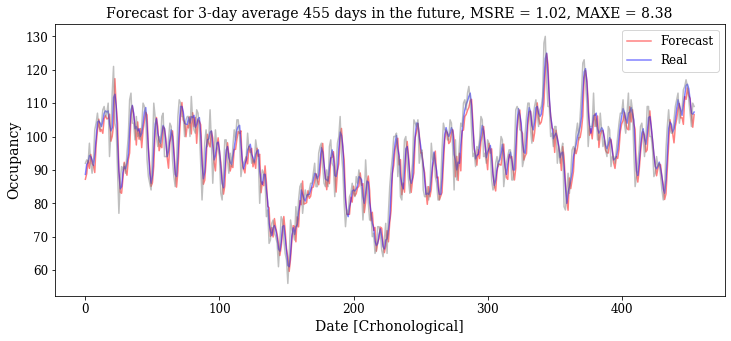

In [23]:
plt.figure(figsize=(12,5))

plt.plot(y_lf_forecast, color='red', alpha=0.5, label='Forecast')
plt.plot(y_lf_test, color='blue', alpha=0.5, label='Real')

plt.plot(y_test, color='gray', alpha=0.5)


plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Forecast for 3-day average 455 days in the future, MSRE = %.2f, MAXE = %.2f'%(MSRE, MAXE), fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.savefig('forecasting_lf.png', bbox='tight')
plt.show()

## High Frequency

In [24]:
X_hf = hf_predictors.values

X_hf_train = X_hf[0:int(f*l)]
X_hf_test = X_hf[int(f*l):]
y_hf_train = hf_y[0:int(f*l)]
y_hf_test = hf_y[int(f*l):]

In [25]:
model_hf = MLPRegressor(activation='relu',solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(250, 250), random_state=1,
                    max_iter=1500,  warm_start=True)

In [26]:
y_hf_forecast = np.array([])
y_hf_ub = np.array([])
y_hf_lb = np.array([])

X_aux = X_hf_train
y_aux = y_hf_train


for i in range(7):
    l_aux = X_aux.shape[0]
    aux_forecast = np.array([])
    model_hf.fit(X_aux, y_aux)
    forecast = model_hf.predict(X_hf_test[i].reshape(1,-1))
        
    y_hf_forecast = np.append(y_hf_forecast, forecast)

    X_aux = np.append(X_hf_train, [X_hf_test[i]], axis=0)
    y_aux = np.append(y_hf_train, y_hf_test[i])

In [27]:
MSRE = np.sqrt(np.sum(y_hf_forecast+y_lf_forecast[0:7]-y_test[0:7])**2)/len(y_test[0:7])
MAXE = np.max(np.abs(y_hf_forecast+y_lf_forecast[0:7]-y_test[0:7]))

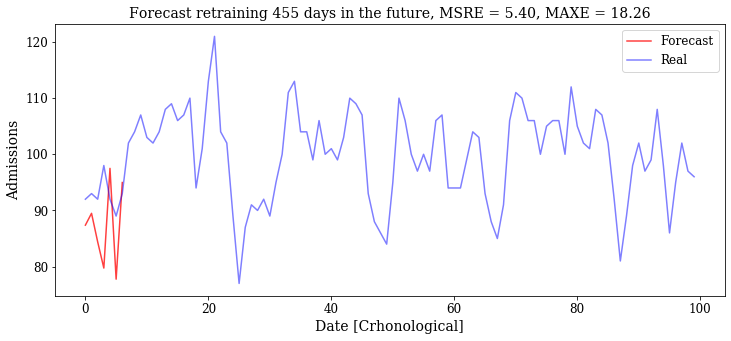

In [28]:
plt.figure(figsize=(12,5))

plt.plot(y_hf_forecast+y_lf_forecast[0:7], color='red', alpha=0.75, label='Forecast')
#plt.plot(y_lf_forecast[0:100], color='gray',alpha=0.5)
#plt.plot(y_lf_test[0:100], color='gray',alpha=0.5)


plt.plot(y_test[0:100], color='blue', alpha=0.5, label='Real')


plt.ylabel('Admissions', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Forecast retraining 455 days in the future, MSRE = %.2f, MAXE = %.2f'%(MSRE, MAXE), 
          fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.savefig('forecasting.png', bbox='tight')
plt.show()

In [29]:
model_hf = MLPRegressor(activation='relu',solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(300, 300), random_state=1,
                    max_iter=1000,  warm_start=True)

## Everything at once

In [30]:
model_hf.fit(X_hf_train, y_hf_train)

MLPRegressor(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(300, 300), learning_rate='constant',
             learning_rate_init=0.001, max_iter=1000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=True)

In [31]:
forecast = model_hf.predict(X_hf_test)

In [39]:
MSRE = np.sqrt(np.sum((forecast+y_lf_forecast-y_test)**2))/np.sqrt(len(y_lf_test))
MAXE = np.max(np.abs(forecast+y_lf_forecast-y_test))
DEV = forecast+y_lf_forecast-y_test

In [40]:
P = 100*(1-np.abs(DEV/y_test))

In [41]:
threshold = np.linspace(0, 99, 100)

In [42]:
accuracy = np.array([])
for confidence in threshold:
    aux = len(P[P>confidence])/len(P)
    accuracy = np.append(accuracy, aux)

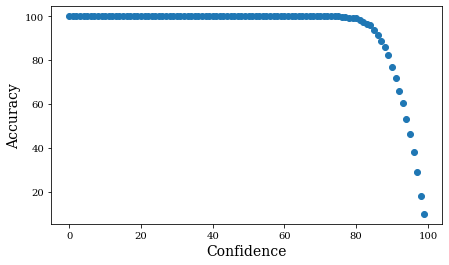

In [43]:
plt.figure(figsize=(7,4))
plt.scatter(threshold, 100*accuracy)
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [44]:
accuracy[threshold == 85]

array([0.93846154])

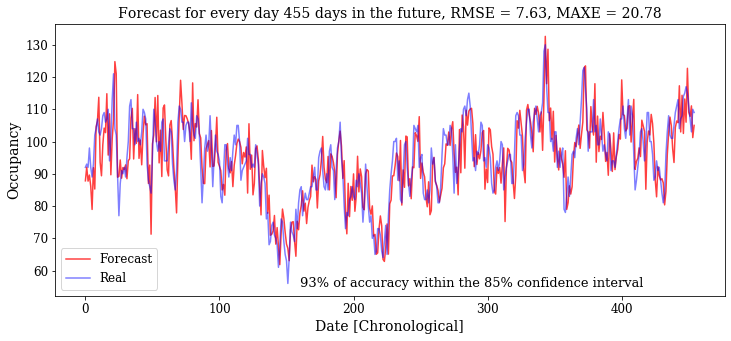

In [45]:
plt.figure(figsize=(12,5))

plt.plot(forecast+y_lf_forecast, color='red', alpha=0.75, label='Forecast')
plt.plot(y_test, color='blue', alpha=0.5, label='Real')


plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Chronological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Forecast for every day 455 days in the future, RMSE = %.2f, MAXE = %.2f'%(MSRE, MAXE), fontsize=14)
plt.text(160, 55, '93% of accuracy within the 85% confidence interval', fontsize=13)
plt.savefig('forecasting.png', bbox='tight')
plt.show()